# Deep Learning
    Session 11
    Classification of fashion mnist data

In [1]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('bmh')

TEST_SIZE = 0.2 # Test size

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
ES_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5

<Figure size 1500x900 with 0 Axes>

In [3]:
test_data = pd.read_csv("./datasets/fashion-mnist_test.csv")
train_data = pd.read_csv("./datasets/fashion-mnist_train.csv")

In [4]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class_names = {0:"T-Shirt/Top", 
               1:"Trouser", 
               2:"Pullover", 
               3:"Dress", 
               4:"Coat", 
               5:"Sandal", 
               6:"Shirt", 
               7:"Sneaker", 
               8:"Bag", 
               9:"Ankle Boot"}

In [7]:
train_data.shape, test_data.shape

((60000, 785), (10000, 785))

In [8]:
train_data['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

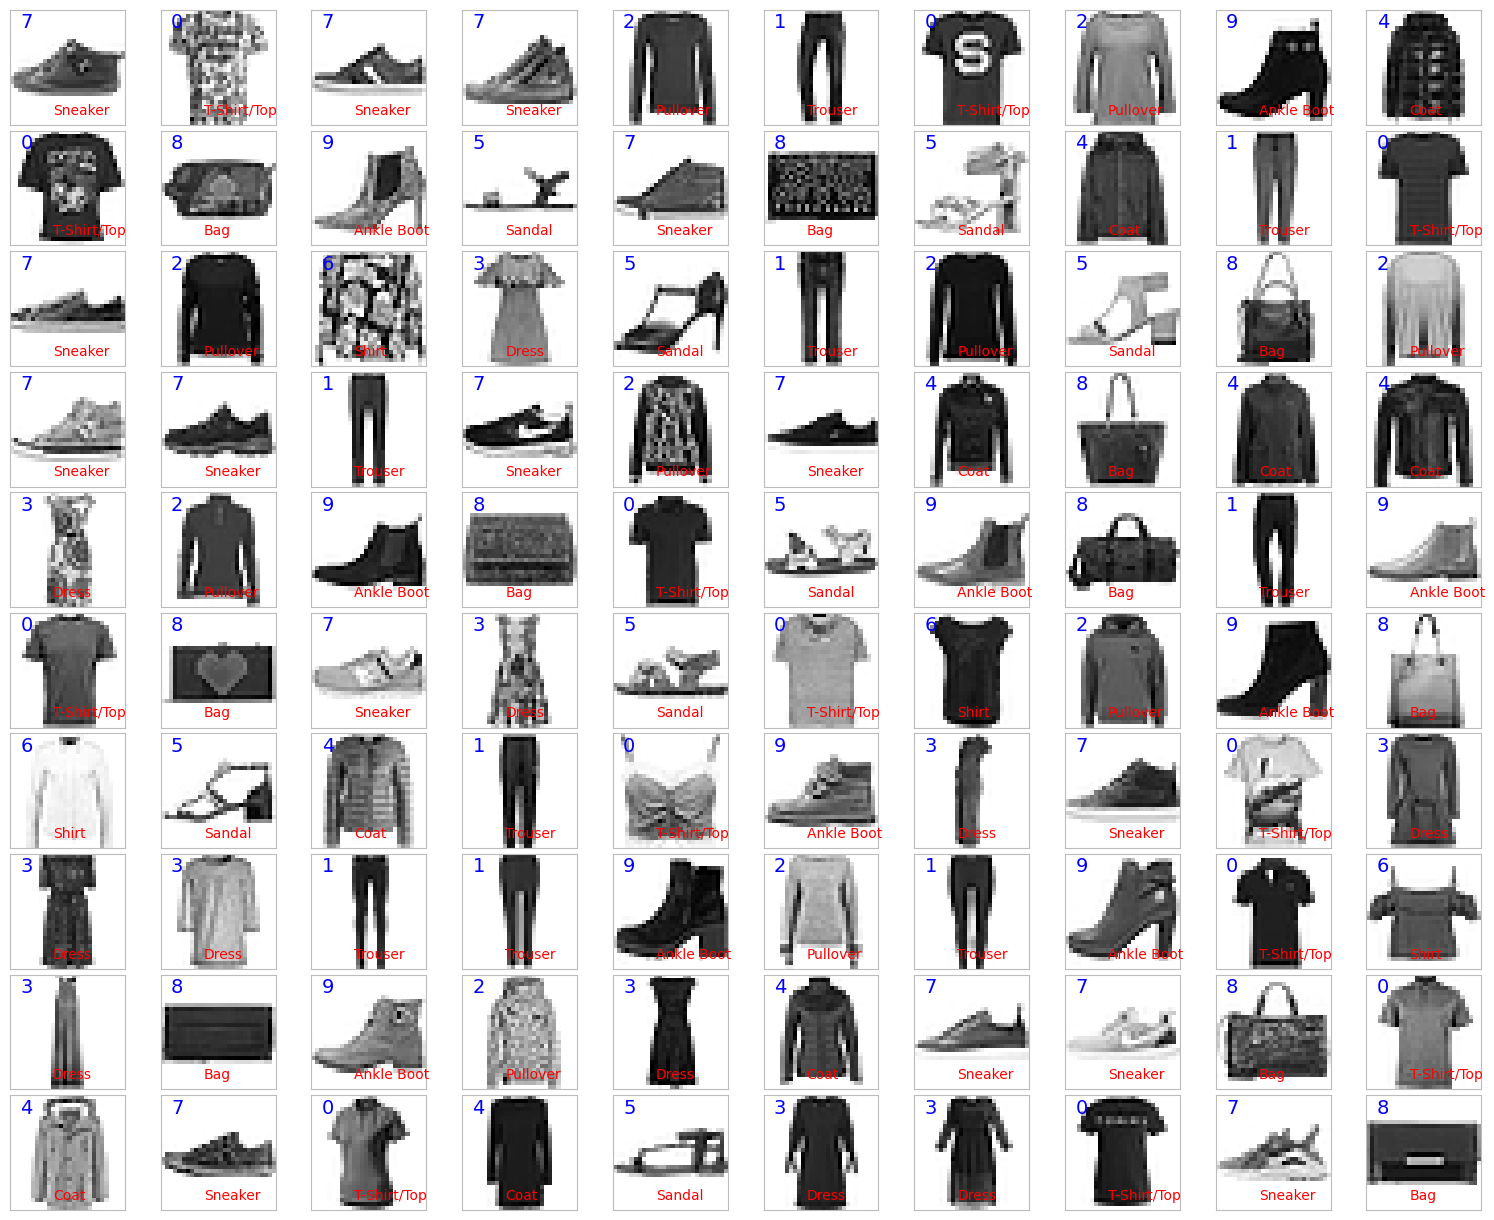

In [9]:
# Sample data plot
plot_df = train_data.sample(n = 100) # Take 100 sample from the training set
fig = plt.figure(figsize=(15, 12))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe    
    i = i + 1    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis    
    ax.text(2, 4, str(row[0]), color='b', fontsize=14)   # add number (class) of the image    
    ax.text(10, 25, class_names[row[0]], color='r', fontsize=10)   # add name of the image
    
plt.show()

In [10]:
x_train = train_data.drop("label", axis=1).to_numpy()
y_train = train_data.label.to_numpy()

x_test = test_data.drop("label", axis=1).to_numpy()
y_test = test_data.label.to_numpy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [11]:
x_train.max()

255

In [12]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [13]:
import tensorflow as tf
import cv2

2023-01-30 17:37:52.694366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 17:37:52.808686: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-30 17:37:53.438300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 17:37:53.438365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [14]:
def build_model():
    dor1 = 0.25
    dor2 = 0.35
    l_2 = 0.01
    
    model = tf.keras.Sequential([      
        tf.keras.layers.Dense(784//2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),    
        
        tf.keras.layers.Dense(784//4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),
        
        tf.keras.layers.Dense(784//8),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),
        
        tf.keras.layers.Dense(10)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    return model

In [15]:
def build_model_1():
    dor1 = 0.25
    dor2 = 0.35
    l_2 = 0.01
    
    model = tf.keras.Sequential([      
        tf.keras.layers.Dense(784//2, kernel_regularizer=tf.keras.regularizers.L2(l2=l_2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),    
        
        tf.keras.layers.Dense(784//4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),
        
        tf.keras.layers.Dense(784//8),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dor1),
        
        tf.keras.layers.Dense(10)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    return model

In [16]:
model = build_model()

2023-01-30 17:37:54.159117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-30 17:37:54.159160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pankajgharde): /proc/driver/nvidia/version does not exist
2023-01-30 17:37:54.159574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
checkpoint_dir = "model"
altName = "no_frils"
#checkpoint_dir = os.path.join(modelDir, subDir)
checkpoint_prefix = os.path.join(checkpoint_dir, altName)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor="val_loss",
                                                    mode="auto",
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

#Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(  monitor="val_loss",
                                                    restore_best_weights=True,
                                                    patience=ES_PATIENCE,
                                                    verbose=1)

#Reduction schedule for alpha
#Early Stopping
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(   monitor="val_loss",
                                                    factor=LR_FACTOR,
                                                    patience=LR_PATIENCE
                                                )

In [18]:
history = model.fit(x_train, y_train,
          validation_data=[x_test, y_test],
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[model_callback, early_callback, lr_reduce])

Epoch 1/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.5728 - accuracy: 0.7984
Epoch 1: val_loss improved from inf to 0.44358, saving model to model/no_frils
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5722 - accuracy: 0.7987 - val_loss: 0.4436 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 2/100
1867/1875 [============================>.] - ETA: 0s - loss: 0.4403 - accuracy: 0.8439
Epoch 2: val_loss improved from 0.44358 to 0.41011, saving model to model/no_frils
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4401 - accuracy: 0.8439 - val_loss: 0.4101 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/100
1869/1875 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8548
Epoch 3: val_loss did not improve from 0.41011
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4034 - accuracy: 0.8547 - val_loss: 0.4287 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 4/100
1868/1875 [============================>.] 

1875/1875 [==============================] - 9s 5ms/step - loss: 0.1863 - accuracy: 0.9312 - val_loss: 0.2595 - val_accuracy: 0.9083 - lr: 5.0000e-04
Epoch 28/100
1871/1875 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9314
Epoch 28: val_loss did not improve from 0.25951
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1809 - accuracy: 0.9314 - val_loss: 0.2708 - val_accuracy: 0.9079 - lr: 5.0000e-04
Epoch 29/100
1867/1875 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9337
Epoch 29: val_loss did not improve from 0.25951
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1782 - accuracy: 0.9337 - val_loss: 0.2595 - val_accuracy: 0.9096 - lr: 5.0000e-04
Epoch 30/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9341
Epoch 30: val_loss improved from 0.25951 to 0.25859, saving model to model/no_frils
1875/1875 [==============================] - 9s 5ms/step - loss: 0.176

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 392)               307720    
                                                                 
 batch_normalization (BatchN  (None, 392)              1568      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 392)               0         
                                                                 
 dropout (Dropout)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 196)               77028     
                                                                 
 batch_normalization_1 (Batc  (None, 196)              784       
 hNormalization)                                        

In [20]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.572227,0.798650,0.443583,0.8393,0.001
1,0.440098,0.843917,0.410110,0.8490,0.001
2,0.403415,0.854750,0.428742,0.8488,0.001
3,0.374697,0.865650,0.361771,0.8600,0.001
4,0.353981,0.871667,0.308426,0.8845,0.001


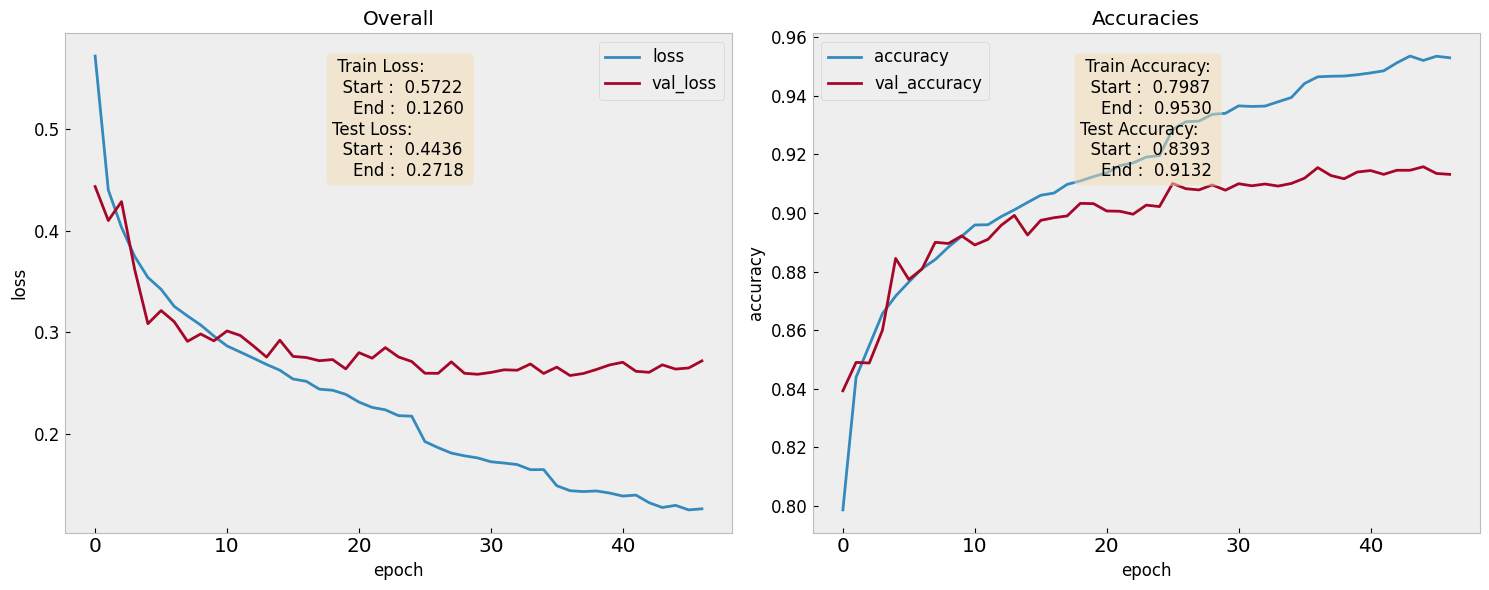

In [21]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 10 # ignoring first few records
y1_var = 'loss'
y2_var = 'val_loss'

ax = axes[0]

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot
test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'accuracy'
y2_var = 'val_accuracy'

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy: ", test_acc)

313/313 - 1s - loss: 0.2574 - accuracy: 0.9155 - 509ms/epoch - 2ms/step

Test accuracy:  0.9154999852180481


In [23]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [24]:
prediction = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [25]:
prediction.shape

(10000, 10)

In [26]:
prediction[0]

array([9.8252791e-01, 3.0303508e-07, 1.2882069e-03, 1.6044230e-04,
       3.7761049e-05, 7.2523301e-07, 1.5970625e-02, 2.1715179e-07,
       1.3900910e-05, 6.8188328e-08], dtype=float32)

In [27]:
prediction[0].sum()

1.0000002

In [28]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'model/no_frils'

In [29]:
#Create a new model instance
model1 = build_model()

#Load the previously saved
model1.load_weights(latest)

#Re-evalute the model
loss, acc = model1.evaluate(x_test, y_test, verbose=2)
print("Restored model, acuracy: {:5.2f}%".format(100 * acc))

313/313 - 1s - loss: 0.2574 - accuracy: 0.9155 - 776ms/epoch - 2ms/step
Restored model, acuracy: 91.55%


In [30]:
y_pred = model1.predict(x_test)
y_pred

313/313 [==============================] - 1s 2ms/step


array([[  4.247289 , -10.744501 ,  -2.3895884, ..., -11.077753 ,
         -6.918641 , -12.236076 ],
       [-10.425927 ,  18.144716 , -15.2864485, ..., -20.21954  ,
        -16.1099   , -18.5989   ],
       [ -2.6024423, -10.298964 ,   3.9687715, ..., -12.183962 ,
        -11.061389 , -12.781832 ],
       ...,
       [-10.9155035, -25.403563 , -15.914292 , ..., -14.56835  ,
         13.861394 , -20.440351 ],
       [ -4.495686 , -15.360156 ,  -7.698396 , ...,  -9.655147 ,
          4.7825823, -10.95861  ],
       [ -7.270246 ,   4.833818 ,  -3.4197726, ..., -11.332117 ,
         -6.8401074,  -8.573446 ]], dtype=float32)

In [31]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
cm

array([[893,   0,  14,  13,   4,   0,  72,   0,   4,   0],
       [  0, 995,   0,   3,   0,   0,   2,   0,   0,   0],
       [ 19,   0, 839,  13,  76,   1,  50,   0,   2,   0],
       [ 18,  13,   6, 923,  25,   0,  14,   0,   1,   0],
       [  2,   0,  43,  20, 908,   0,  27,   0,   0,   0],
       [  0,   0,   0,   0,   0, 960,   1,  23,   1,  15],
       [122,   3,  57,  23,  62,   0, 731,   0,   2,   0],
       [  0,   0,   0,   0,   0,   8,   0, 962,   0,  30],
       [  4,   1,   6,   2,   2,   0,   4,   2, 979,   0],
       [  1,   0,   0,   0,   0,   4,   0,  29,   1, 965]])

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

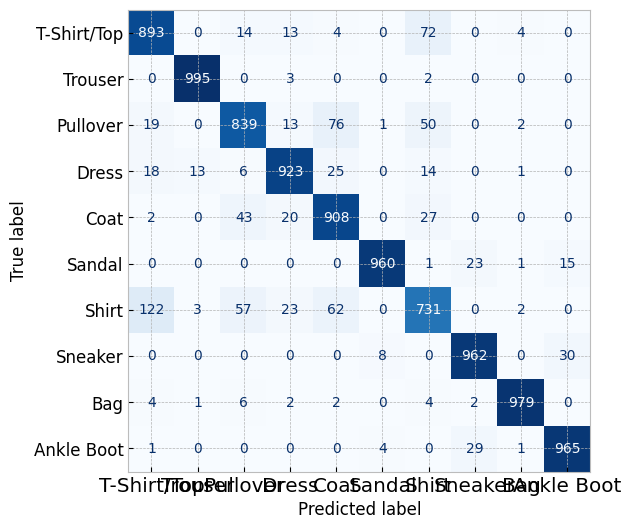

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.show()

# Savinge model

In [34]:
model_path = checkpoint_prefix+'.h5'
model.save(model_path, save_format='h5')

In [35]:
new_model = tf.keras.models.load_model(model_path)

In [36]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 392)               307720    
                                                                 
 batch_normalization (BatchN  (None, 392)              1568      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 392)               0         
                                                                 
 dropout (Dropout)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 196)               77028     
                                                                 
 batch_normalization_1 (Batc  (None, 196)              784       
 hNormalization)                                        